In [1]:
# Import library yang diperlukan
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load data ke dalam data frame dan spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('sentimen_S-NS.csv', encoding='latin-1') 

df.head()

,review_tokens_SR,Sentimen,sentimen,classified_text,tweet_text,sentence_score,max_positive,max_negative,kelas
0,kecewa banget pesan free pouch dikirimnya cott...,Negatif,{'classified_text': 'kecewa [-4] banget pesan ...,kecewa [-4] banget pesan free pouch dikirimnya...,kecewa banget pesan free pouch dikirimnya cot...,['kecewa [-4] banget pesan free pouch dikirimn...,5,-4,positif
1,kali pengemasan safe sepertinya tutup botol ke...,Negatif,{'classified_text': 'kali pengemasan safe sepe...,kali pengemasan safe sepertinya tutup botol ke...,kali pengemasan safe sepertinya tutup botol k...,['kali pengemasan safe sepertinya tutup botol ...,4,-3,positif
2,paket datangnya barang pecah return seller iku...,Negatif,{'classified_text': 'paket datangnya barang pe...,paket datangnya barang pecah [-2] return selle...,paket datangnya barang pecah return seller ik...,['paket datangnya barang pecah [-2] return sel...,1,-4,negatif
3,enggak sabun nya enggak sesuai deskripsi,Negatif,{'classified_text': 'enggak sabun nya enggak s...,enggak sabun nya enggak sesuai [-3] deskripsi,enggak sabun nya enggak sesuai deskripsi,['enggak sabun nya enggak sesuai [-3] deskripsi'],1,-3,negatif
4,enggak sesuai harapan,Negatif,{'classified_text': 'enggak sesuai [-3] harapa...,enggak sesuai [-3] harapan [4],enggak sesuai harapan,['enggak sesuai [-3] harapan [4]'],4,-3,positif


In [3]:
# Drop 3 kolom terakhir yang tidak digunakan dengan fungsi iloc
df = df.drop(df.iloc[:,1:8], axis=1)

# Cek data teratas
df.head()

,review_tokens_SR,kelas
0,kecewa banget pesan free pouch dikirimnya cott...,positif
1,kali pengemasan safe sepertinya tutup botol ke...,positif
2,paket datangnya barang pecah return seller iku...,negatif
3,enggak sabun nya enggak sesuai deskripsi,negatif
4,enggak sesuai harapan,positif


In [4]:
# Data untuk rename kolom v1 dan v2
new_cols = {
    'review_tokens_SR' : 'Review',
    'kelas' : 'Sentimen'
}

# Rename nama kolom v1 dan v2
df = df.rename(columns=new_cols)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget pesan free pouch dikirimnya cott...,positif
1,kali pengemasan safe sepertinya tutup botol ke...,positif
2,paket datangnya barang pecah return seller iku...,negatif
3,enggak sabun nya enggak sesuai deskripsi,negatif
4,enggak sesuai harapan,positif


In [5]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

positif    143
netral      57
negatif     47
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    247 non-null    object
 1   Sentimen  247 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None


              Review Sentimen
count            247      247
unique           239        3
top     terima kasih  positif
freq               3      143


In [6]:
# Data untuk label
new_labels = {
    'negatif' : 0,
    'netral' : 1,
    'positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget pesan free pouch dikirimnya cott...,2
1,kali pengemasan safe sepertinya tutup botol ke...,2
2,paket datangnya barang pecah return seller iku...,0
3,enggak sabun nya enggak sesuai deskripsi,0
4,enggak sesuai harapan,2


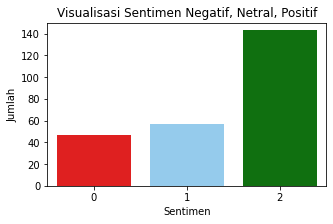

In [7]:
# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentimen', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [8]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentimen'].values

In [9]:
# Inisialisasi model
cnb = ComplementNB(alpha=1.0 , fit_prior=True, class_prior=None)

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions_testing = []
all_true_labels_testing = []
all_predictions_training = []
all_true_labels_training = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = vectorizer.fit_transform(X_train)
    X_test_transform = vectorizer.transform(X_test)

    # Melatih model klasifikasi pada data latih
    cnb.fit(X_train_transform, y_train)

    # Membuat prediksi pada data uji
    predictions_testing = cnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_testing.extend(predictions_testing)
    all_true_labels_testing.extend(y_test)

    # Membuat prediksi pada data training
    predictions_training = cnb.predict(X_train_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_training.extend(predictions_training)
    all_true_labels_training.extend(y_train)

In [10]:
# Simpan TfidfVectorizer ke dalam file .pickle
vectorizer_filename = 'tfidf-SNS.pickle'
joblib.dump(vectorizer, vectorizer_filename)

# Simpan model ke dalam file .pickle
model_filename = 'model-SNS.pickle'
joblib.dump(cnb, model_filename)

['model-SNS.pickle']

In [10]:
# Hitung metrik evaluasi
accuracy_training = accuracy_score(all_true_labels_training, all_predictions_training)
precision_training = precision_score(all_true_labels_training, all_predictions_training, average='weighted')
recall_training = recall_score(all_true_labels_training, all_predictions_training, average='weighted')
f1_training = f1_score(all_true_labels_training, all_predictions_training, average='weighted')

# Print hasil
print("------- AKURASI TRAINING -------")
print("Overall accuracy:", accuracy_training)
print("Overall precision:", precision_training)
print("Overall recall:", recall_training)
print("Overall F1-score:", f1_training)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_training, all_predictions_training)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_training, all_predictions_training, zero_division=0))


------- AKURASI TRAINING -------
Overall accuracy: 0.9382058384828468
Overall precision: 0.9423468883092975
Overall recall: 0.9382058384828468
Overall F1-score: 0.9357556336098758
Confusion Matrix : 
 [[ 864    0   29]
 [  94  827  162]
 [   5    0 2712]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       893
           1       1.00      0.76      0.87      1083
           2       0.93      1.00      0.97      2717

    accuracy                           0.94      4693
   macro avg       0.94      0.91      0.92      4693
weighted avg       0.94      0.94      0.94      4693



In [11]:
# Hitung metrik evaluasi
accuracy_testing = accuracy_score(all_true_labels_testing, all_predictions_testing)
precision_testing = precision_score(all_true_labels_testing, all_predictions_testing, average='weighted')
recall_testing = recall_score(all_true_labels_testing, all_predictions_testing, average='weighted')
f1_testing = f1_score(all_true_labels_testing, all_predictions_testing, average='weighted')

# Print hasil
print("------- AKURASI TESTING -------")
print("Overall accuracy:", accuracy_testing)
print("Overall precision:", precision_testing)
print("Overall recall:", recall_testing)
print("Overall F1-score:", f1_testing)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_testing, all_predictions_testing)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_testing, all_predictions_testing, zero_division=0))

------- AKURASI TESTING -------
Overall accuracy: 0.6882591093117408
Overall precision: 0.6804251012145749
Overall recall: 0.6882591093117408
Overall F1-score: 0.656717161490402
Confusion Matrix : 
 [[ 26   3  18]
 [ 15  14  28]
 [  9   4 130]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.52      0.55      0.54        47
           1       0.67      0.25      0.36        57
           2       0.74      0.91      0.82       143

    accuracy                           0.69       247
   macro avg       0.64      0.57      0.57       247
weighted avg       0.68      0.69      0.66       247



In [12]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = cnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  positif
